In [1]:
from toolbox.models import ResNet112, ResNet56
from toolbox.data_loader import Cifar100
from toolbox.utils import evaluate_model

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorly as tl
from tensorly import tucker_to_tensor

import matplotlib.pyplot as plt

device = "cuda"
BATCH_SIZE = 128


In [2]:
model_path = r"toolbox/Cifar100_ResNet112.pth"
teacher = ResNet112(100).to(device)
teacher.load_state_dict(torch.load(model_path, weights_only=True)["weights"])
teacher.eval()

student = ResNet56(100).to(device)
student.train()

mean, std = (0.5071, 0.4867, 0.4409), (0.267, 0.256, 0.276) 
Data = Cifar100(BATCH_SIZE)
trainloader, testloader = Data.trainloader, Data.testloader

evaluate_model(teacher, testloader)

Files already downloaded and verified
Files already downloaded and verified
TEST | Loss: 1.125 | Acc: 74.040 |


(1.1252409513992598, 74.04)

In [3]:
inputs, targets = next(iter(trainloader))
inputs, targets = inputs.to(device), targets.to(device)

teacher_outputs = teacher(inputs)
student_outputs = student(inputs)

active_outputs = teacher_outputs

index = 0

In [4]:
probs = torch.nn.functional.softmax(active_outputs[3], dim=1)
confidence, predicted = torch.max(probs.data, 1)
predicted_class_label = testloader.dataset.classes[predicted[index]]
correct_class_label = testloader.dataset.classes[targets[index]]

print('predicted: ', predicted_class_label)
print('correct: ', correct_class_label)
print('confidence', confidence[index].item())


img = inputs[index].cpu() * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
img = img.permute(1, 2, 0).numpy()

predicted:  turtle
correct:  turtle
confidence 0.9421891570091248


In [5]:

tl.set_backend("pytorch")
def tucker(feature_map): #expects 4d
    batch_size, channels, height, width = feature_map.shape
    core, factors = tl.decomposition.tucker(feature_map, rank=[BATCH_SIZE, 24, 6, 6])
    return core, factors

def compute_core(feature_map, factors):
    return tl.tenalg.multi_mode_dot(feature_map, [f.T for f in factors], modes=[0, 1, 2, 3])




In [6]:
teacher_core, teacher_factors = tucker(teacher_outputs[2])
student_core = compute_core(student_outputs[2], teacher_factors)

teacher_reconstructed = tucker_to_tensor((teacher_core, teacher_factors))
student_reconstructed = tucker_to_tensor((student_core, teacher_factors))

In [7]:
def show_fmap(fmap):
    size = 2
    fig, axs = plt.subplots(size, size)  # You can adjust the figsize as needed
    for i in range(size):
        for j in range(size):
            axs[i,j].matshow(fmap[i], vmin=0, vmax=10)
            axs[i,j].axis('off')  # Hide axis for clarity

    plt.tight_layout()
    plt.show()

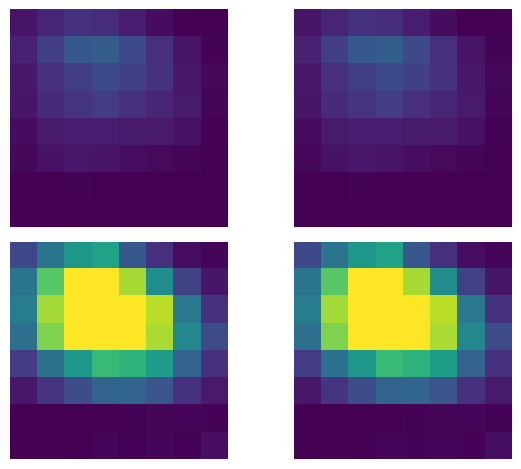

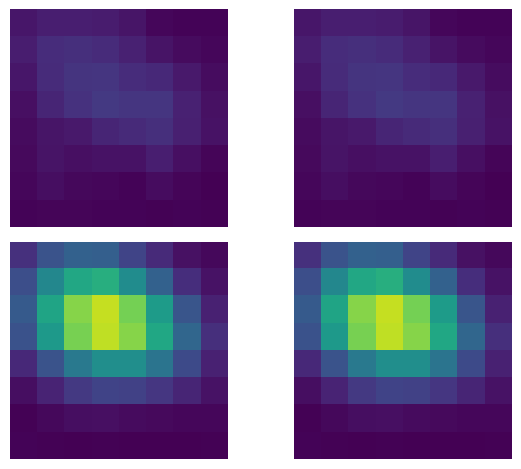

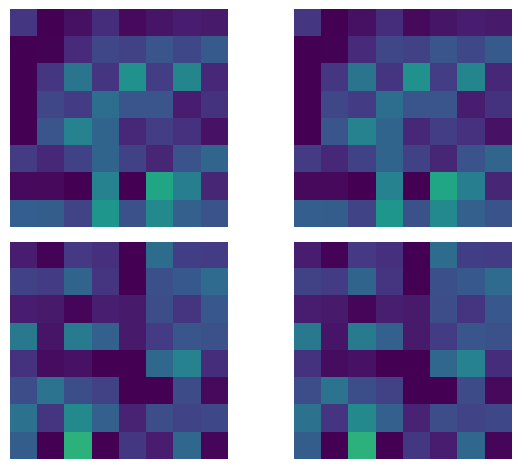

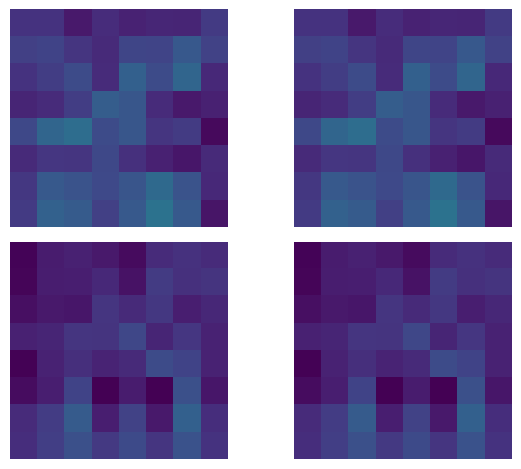

In [8]:
teacher_sample = teacher_outputs[2][0].detach().cpu()
teacher_reconstructed_sample = teacher_reconstructed[0].detach().cpu()


student_sample = student_outputs[2][0].detach().cpu()
student_reconstructed_sample = student_reconstructed[0].detach().cpu()

for fmap in [teacher_sample, teacher_reconstructed_sample, student_sample, student_reconstructed_sample]:
    show_fmap(fmap)



# TESTING

In [ ]:
from toolbox.models import ResNet112, ResNet56
from toolbox.data_loader import Cifar100
from toolbox.utils import plot_the_things, evaluate_model

import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import tensorly as tl

from pathlib import Path
import argparse

DEVICE = "cuda"

# Hyperparameters
EPOCHS = 150
BETA = 125
BATCH_SIZE = 128*4

In [9]:

# Functions
tl.set_backend("pytorch")
def tucker(feature_map, ranks=[BATCH_SIZE, 32, 8, 8]): 
    core, factors = tl.decomposition.tucker(feature_map, rank=ranks)
    return core, factors

def compute_core(feature_map, factors):
    return tl.tenalg.multi_mode_dot(feature_map, [f.T for f in factors], modes=[0, 1, 2, 3])

def FT(x):
    return F.normalize(x.reshape(x.size(0), -1))




def feature_map_distillation(teacher_outputs, student_outputs, targets):
    beta = 125
    teacher_fmap = teacher_outputs[2]
    student_fmap = student_outputs[2]
    brute_loss = 125 * F.l1_loss(FT(teacher_fmap), FT(student_fmap))
    hard_loss = F.cross_entropy(student_outputs[3], targets)
    return brute_loss + hard_loss

In [4]:

# Model setup
model_path = r"toolbox/Cifar100_ResNet112.pth"
teacher = ResNet112(100).to(DEVICE)
teacher.load_state_dict(torch.load(model_path, weights_only=True)["weights"])

student = ResNet56(100).to(DEVICE)

Data = Cifar100(BATCH_SIZE)
trainloader, testloader = Data.trainloader, Data.testloader

optimizer = optim.SGD(student.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
inputs, targets = next(iter(trainloader))
inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

teacher_outputs = teacher(inputs)
student_outputs = student(inputs)

teacher.eval()
student.train()

ResNet56

In [ ]:
# Arguments


experiment_path = "test"
Path(f"experiments/{experiment_path}").mkdir(parents=True, exist_ok=True)


In [22]:
def show_fmap(fmap):
    fmap = fmap[0].detach().cpu().numpy()
    print(fmap.shape)
    fig, axes = plt.subplots(8, 8, figsize=(5, 5))  # You can adjust the figsize as needed
    for i in range(64):
        row = i // 8
        col = i % 8 
        ax = axes[row, col]
        ax.matshow(fmap[i])
        ax.axis('off')  # Hide axis for clarity

    plt.tight_layout()
    plt.show()

(64, 8, 8)


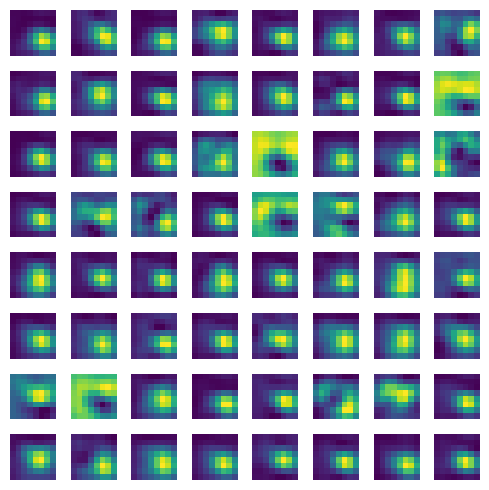

(64, 8, 8)


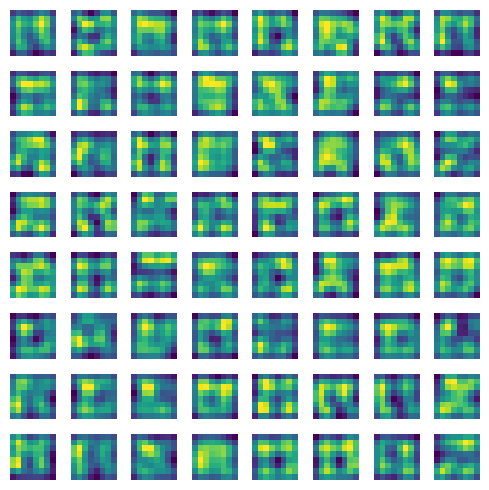

In [26]:
def tucker_distillation(teacher_outputs, student_outputs, targets, ranks=None):
    teacher_fmap = teacher_outputs[2]
    student_fmap = student_outputs[2]

    teacher_core , teacher_factors = tucker(teacher_fmap, ranks)
    student_core = compute_core(student_fmap, teacher_factors)

    tucker_loss = BETA * F.l1_loss(FT(teacher_core), FT(student_core))
    hard_loss = F.cross_entropy(student_outputs[3], targets)
    return tucker_loss + hard_loss

def tucker_recomp_distillation(teacher_outputs, student_outputs, targets,recomp_target,ranks=None): # Decomposes and recomposes teacher feature map
    teacher_fmap = teacher_outputs[2]
    student_fmap = student_outputs[2]

    teacher_core , teacher_factors = tucker(teacher_fmap, ranks)
    if recomp_target == 'teacher':
        teacher_reconstructed = tl.tucker_to_tensor((teacher_core, teacher_factors))
        show_fmap(teacher_reconstructed)
        show_fmap(student_fmap)
        brute_loss = 125 * F.l1_loss(FT(teacher_reconstructed), FT(student_fmap))
    elif recomp_target == 'student':
        student_core = compute_core(student_fmap, teacher_factors)
        student_reconstructed = tl.tucker_to_tensor((student_core, teacher_factors))
        show_fmap(teacher_fmap)
        show_fmap(student_reconstructed)
        brute_loss = 125 * F.l1_loss(FT(teacher_fmap), FT(student_reconstructed))
    elif recomp_target == 'both':
        student_core = compute_core(student_fmap, teacher_factors)
        teacher_reconstructed = tl.tucker_to_tensor((teacher_core, teacher_factors))
        student_reconstructed = tl.tucker_to_tensor((student_core, teacher_factors))
        show_fmap(teacher_reconstructed)
        show_fmap(student_reconstructed)
        brute_loss = 125 * F.l1_loss(FT(teacher_reconstructed), FT(student_reconstructed))

    hard_loss = F.cross_entropy(student_outputs[3], targets)
    return brute_loss + hard_loss



Distillation = tucker_recomp_distillation
Ranks = [BATCH_SIZE, 16, 4, 4]
Recomp_target = 'both'

if Distillation.__name__ == 'feature_map_distillation':
    loss = Distillation(teacher_outputs, student_outputs, targets)
else:
    if Distillation.__name__ == 'tucker_recomp_distillation':
        loss = Distillation(teacher_outputs, student_outputs, targets, Recomp_target, Ranks)
    else:
        loss = Distillation(teacher_outputs, student_outputs, targets, Ranks)